# Importiamo il dataset e facciamo ETL

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#importing dataset
australia = pd.read_csv('path../AUS.csv', header = 0)

new_names = {'Date': 'date', 'Location': 'location','MinTemp': 'min_temp', 
            'MaxTemp': 'max_temp', 'Rainfall':'rainfall', 'Evaporation': 'evaporation', 'Sunshine': 'sunshine', 
            'WindGustDir':'wind_gust_dir', 'WindGustSpeed': 'wind_gust_speed', 'WindDir9am': 'wind_dir_9am', 'WindDir3pm': 'wind_dir_3pm',
            'WindSpeed9am': 'wind_speed_9am', 'WindSpeed3pm': 'wind_speed_3pm',
            'Humidity9am':'humidity_9am', 'Humidity3pm':'humidity_3pm', 'Pressure9am':'pressure_9am', 'Pressure3pm':'pressure_3pm',
            'Cloud9am':'cloud_9am', 'Cloud3pm':'cloud_3pm', 'Temp9am':'temp_9am', 'Temp3pm':'temp_3pm',
            'RainToday': 'rain_today', 'RainTomorrow': 'rain_tomorrow' }
australia.rename(columns=new_names, inplace=True)
australia = australia.drop(['sunshine','evaporation'], axis=1)

#correzione del campo wind_dir e wind_speed: mettiamo 0 al posto di null ai campi dir se la velocità del vento è 0 (non c'è vento in quel momento)
australia['wind_dir_9am'] = australia[['wind_dir_9am','wind_speed_9am']].apply(lambda x: '0' if x['wind_speed_9am']==0 else x['wind_dir_9am'], axis=1)
australia['wind_dir_3pm'] = australia[['wind_dir_3pm','wind_speed_3pm']].apply(lambda x: '0' if x['wind_speed_3pm']==0 else x['wind_dir_3pm'], axis=1)

# rimuoviamo i gust perchè sono presi dalle colonne sopra, tra il massimo della giornata
australia = australia.drop(['wind_gust_dir','wind_gust_speed'], axis=1)

#togliamo tutte quelle città che hanno almeno il 40% di null sul campo cloud3pm
location = australia.location.unique()
#print(location)
count = 0
for loc in location:
    #print(loc, len(australia[australia['location']==loc]))
    lung = len(australia[australia['location']==loc])
    if australia[australia['location']==loc].isnull().sum().cloud_3pm > lung * 0.4:
        australia = australia.drop(australia[australia['location'] == loc].index)
        count +=1

australia = australia.dropna(thresh = 16)
australia = australia.ffill(axis=0)

#aggiungiamo la colonna state in funzione della città 

#stati:
sa = ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'] #australia meridionale
wa = ['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums',
      'Walpole'] #australia occidentale
nsw = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport',
       'WaggaWagga', 'Williamtown', 'Wollongong'] #Nuovo Galles del Sud
qld = ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'] #Queensland
tas = ['Hobart', 'Launceston'] #Tasmania
vic = ['Ballarat', 'Bendigo', 'Sale', 'Melbourne', 'MelbourneAirport',
      'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor'] #Victoria
act = ['Camberra', 'Tuggeranong', 'MountGinini'] #territorio della capitale australiana
nt = [ 'AliceSprings', 'Darwin', 'Katherine', 'Uluru'] #Territorio del nord
nfk = ['NorfolkIsland'] #territorio esterno del norfolk
 
#gli ultimi quattro si potrebbero unire anche in un unico territorio del sud est australiano,
#a livello di clima dovrebbero essere molto simii potrebbe avere difficoltà a classificarli

def State(a):
    if a in sa:
        return 'SA'
    elif a in wa:
        return 'WA'
    elif a in nsw:
        return 'NSW'
    elif a in qld:
        return 'QLD'
    elif a in tas:
        return 'TAS'
    elif a in vic:
        return 'VIC'
    elif a in act:
        return 'ACT'
    elif a in nt:
        return 'NT'
    elif a in nfk:
        return 'NFK'
    

#le = preprocessing.LabelEncoder()
#crime['category_id'] = le.fit_transform(australia['state'])

australia['state'] = australia.location.apply(lambda x: str(State(x)))


In [2]:
print((australia.shape))
australia.head(10)

(91337, 20)


In [2]:
#australia.describe()

In [2]:
australia = australia.reset_index()
australia = australia.drop(["index"], axis = 1)
#australia.head()

<AxesSubplot:>

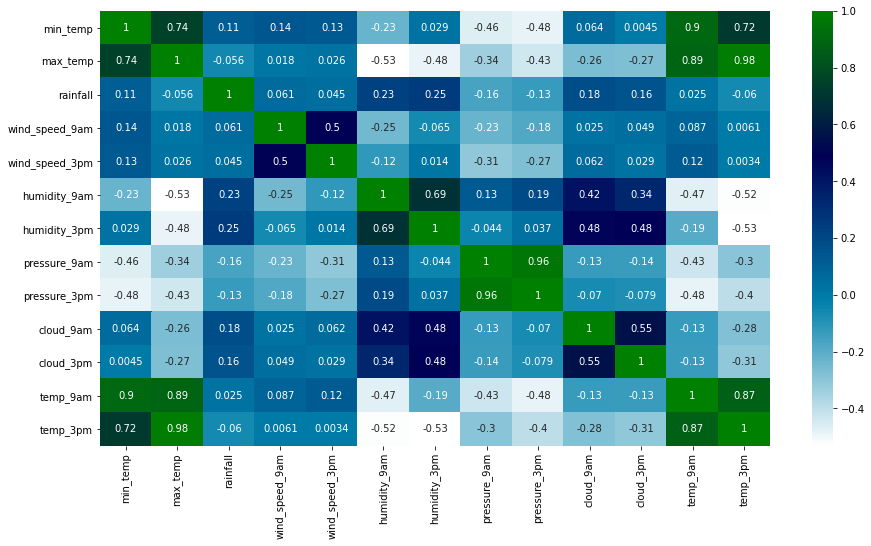

In [4]:
#vediamo l'eventuale correlazione tra le diverse feature
plt.figure(figsize=(15,8))
sns.heatmap(australia.corr(), cmap = 'ocean_r',annot = True)

In [ ]:
#in ottica di classificazione le diverse feature non devono mostrare correlazione, pertanto andremo a rimuovere 
#alcune di queste in modo da avere tutte le feature incorrelate

In [3]:
aus2 = australia.drop(["min_temp", "max_temp", "wind_dir_9am", "wind_speed_9am", "humidity_9am", "pressure_9am", "cloud_9am", "temp_9am" ], axis=1)
# splittiamo la data in giorno, mese, anno poichè la data completa non è utilizzabile per la classificazione
aus2['date'] = pd.to_datetime(aus2['date'])
aus2['day'] = aus2['date'].dt.day
aus2['month'] = aus2['date'].dt.month
aus2['year'] = aus2['date'].dt.year
aus2 = aus2.drop(["date"],axis = 1)
#riordiniamo le colonne 
aus2 = aus2 [["day","month","year","location","rainfall","wind_dir_3pm","wind_speed_3pm","humidity_3pm","pressure_3pm","cloud_3pm","temp_3pm","rain_today","state","rain_tomorrow"]]

In [4]:
#mappiamo i campi string in numerico
from sklearn.preprocessing import MinMaxScaler
le = preprocessing.LabelEncoder()
aus2['location'] = le.fit_transform(aus2['location'])
aus2['wind_dir_3pm'] = le.fit_transform(aus2['wind_dir_3pm'])
aus2['rain_today'] = le.fit_transform(aus2['rain_today'])
aus2['rain_tomorrow'] = le.fit_transform(aus2['rain_tomorrow'])
aus2['state'] = le.fit_transform(aus2['state'])

#facciamo lo scaling di alcuni valori in modo da averli compresi tra 0-1
scaler = MinMaxScaler()
aus2[['rainfall','wind_speed_3pm','humidity_3pm','pressure_3pm','cloud_3pm','temp_3pm']] = scaler.fit_transform(aus2[['rainfall','wind_speed_3pm','humidity_3pm','pressure_3pm','cloud_3pm','temp_3pm']])

<AxesSubplot:>

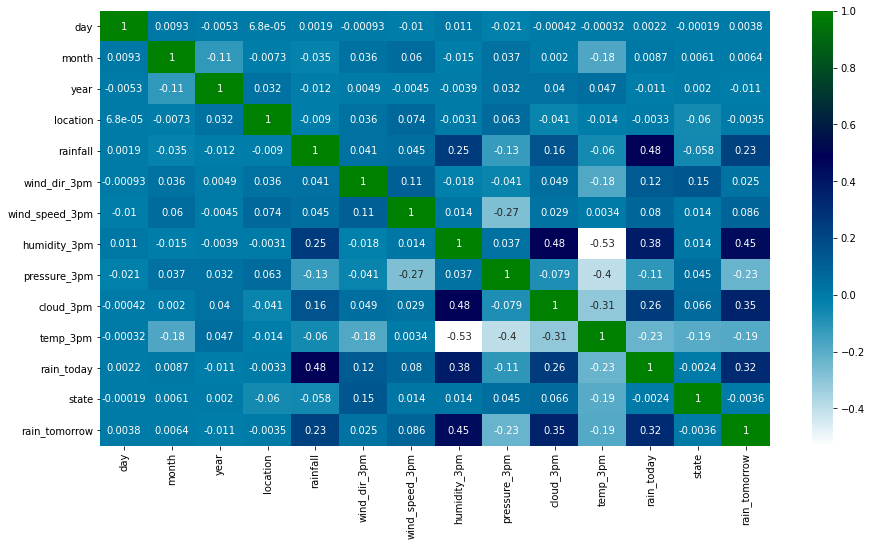

In [7]:
plt.figure(figsize=(15,8))
sns.heatmap(aus2.corr(), cmap = 'ocean_r',annot = True)

In [5]:
#la calssificazione che vogliamo fare è su "rain tomorrow", pertanto la variabile target sarà rain_tomorrow
#vediamo il bilanciamento tra la classe 'si' e 'no'
si = aus2[aus2.rain_tomorrow == 1]
no = aus2[aus2.rain_tomorrow == 0]
print(len(si), len(no))
si.head()
#la classe no è sbilanciata rispetto la si, pertanto andremo a prendere un sottoinsieme della prima

20127 71210


,day,month,year,location,rainfall,wind_dir_3pm,wind_speed_3pm,humidity_3pm,pressure_3pm,cloud_3pm,temp_3pm,rain_today,state,rain_tomorrow
17,19,1,2009,7,0.000000,6,0.108434,0.29,0.525890,0.666667,0.720000,0,1,1
20,22,1,2009,7,0.000000,4,0.228916,0.63,0.470874,0.777778,0.568889,0,1,1
21,23,1,2009,7,0.048518,8,0.084337,0.50,0.478964,0.444444,0.704444,1,1,1
32,3,2,2009,7,0.001617,12,0.132530,0.17,0.451456,0.222222,0.822222,0,1,1
42,13,2,2009,7,0.001617,1,0.421687,0.53,0.567961,0.777778,0.460000,0,1,1


In [6]:
balanced = pd.concat([no.sample(len(si)), si])

#creiamo la variabile delle feature e quella target 
x = balanced.iloc[:,:-1] #features
y = balanced.iloc[:,-1:] #variabile target
print(len(balanced))
x.head()

40254


,day,month,year,location,rainfall,wind_dir_3pm,wind_speed_3pm,humidity_3pm,pressure_3pm,cloud_3pm,temp_3pm,rain_today,state
87290,18,2,2015,1,0.0,11,0.156627,0.18,0.478964,0.555556,0.740000,0,2
40761,24,2,2017,12,0.0,11,0.361446,0.49,0.770227,0.777778,0.366667,0,7
70391,1,1,2017,30,0.0,12,0.397590,0.32,0.532362,0.888889,0.600000,0,5
54728,26,4,2015,4,0.0,14,0.180723,0.30,0.543689,0.111111,0.466667,0,4
7760,12,4,2015,14,0.0,12,0.265060,0.33,0.621359,0.777778,0.542222,0,1


# Classificazione

In [7]:
from sklearn.model_selection import train_test_split 
rs = 42 #random state

# splittiamo con il metodo dell'hold-out
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = rs)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(28177, 13)
(12077, 13)
(28177, 1)
(12077, 1)


In [8]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model libraries

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

#algoritmi di classificazione scelti
classifiers = [
    DecisionTreeClassifier(random_state=rs),
    LinearSVC(random_state=rs),
    KNeighborsClassifier(n_neighbors = 3),
    RandomForestClassifier(n_estimators = 10, random_state=rs)
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=10) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [9]:
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    #train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())
    

Accuracy: 0.71 	 ---> DecisionTreeClassifier 
Accuracy: 0.5 	 ---> SVC 
Accuracy: 0.64 	 ---> KNeighborsClassifier 
Accuracy: 0.77 	 ---> RandomForestClassifier 


Text(0.5, 1.0, 'Cross validation scores')

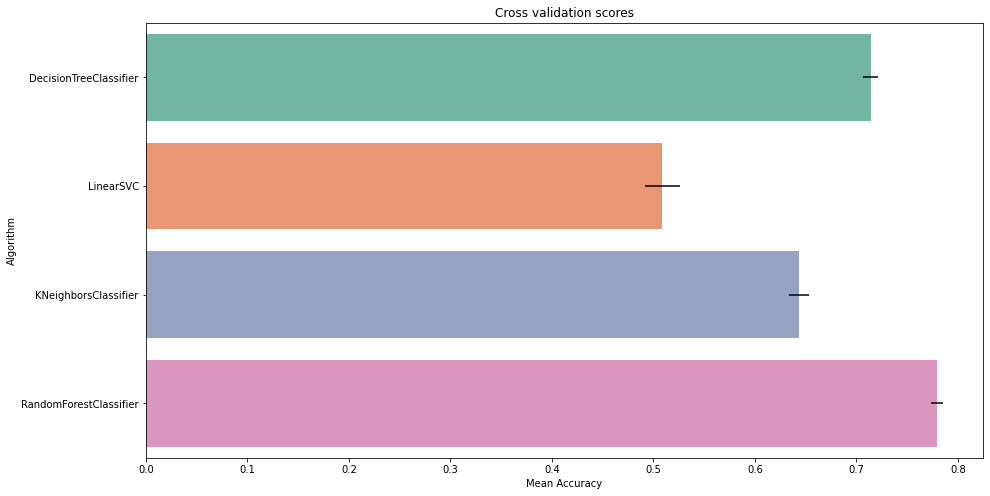

In [13]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(15,8))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

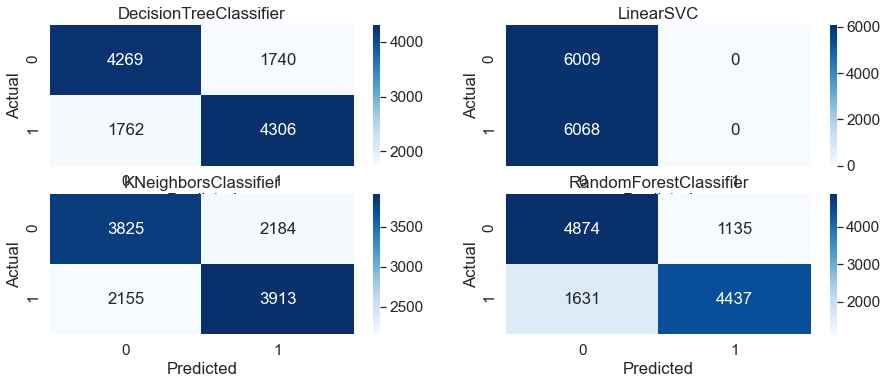

In [14]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(15,15))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(5,2,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

#individuano per ogni classe quante osservazioni sono state classificate bene e quante invece no

I classification reports ci restituiscono le metriche di precision, recall, f1-score e support per ogni classe, per ogni algoritmo di classific.
- supporto: numero di osservazioni per quella classe
- precision: mi dice quante delle cose che lui predice sono vere
- recall: mi dice quante delle cose vere è in grado di predire come vere
- f1-score: media tra le due

In [15]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);


DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71      6009
           1       0.71      0.71      0.71      6068

    accuracy                           0.71     12077
   macro avg       0.71      0.71      0.71     12077
weighted avg       0.71      0.71      0.71     12077

LinearSVC Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      6009
           1       0.00      0.00      0.00      6068

    accuracy                           0.50     12077
   macro avg       0.25      0.50      0.33     12077
weighted avg       0.25      0.50      0.33     12077

KNeighborsClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      6009
           1       0.64      0.64      0.64      6068

    accuracy                           0.64     12077
   ma

# YELLOWBRICK

Utilizzamo yellowbrik per valutare la qualità degli algoritmi, sempre con le 3 metriche viste prima, ma visualizzandole graficamente

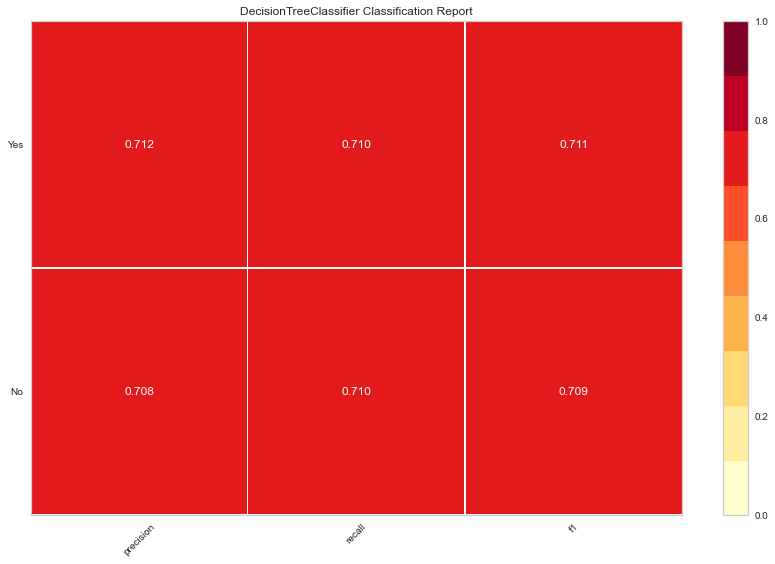

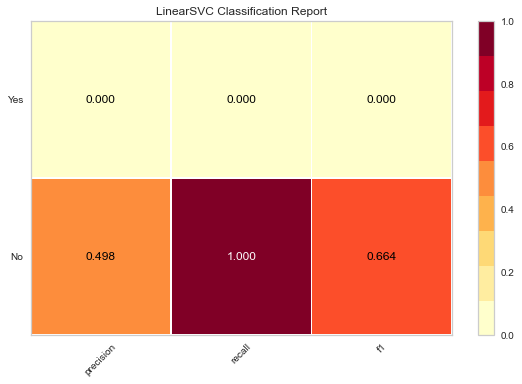

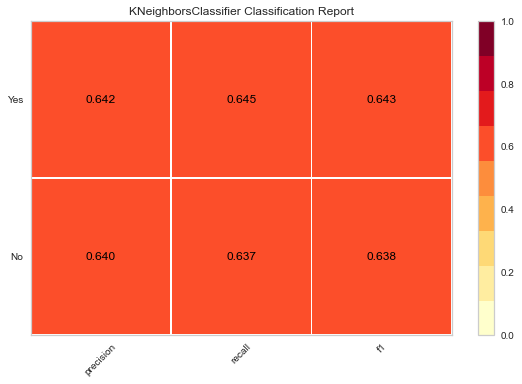

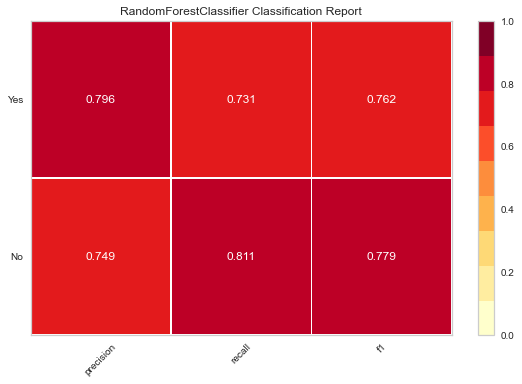

In [16]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassificationReport
from yellowbrick.model_selection import LearningCurve

# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
for clf in classifiers:
    
    visualizer = ClassificationReport(clf, classes = ['No', 'Yes'])
    visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(x_test, y_test)        # Evaluate the model on the test data
    G = visualizer.poof()                      


Andiamo ora a cercare dei parametri ottimali per quanto riguarda gli algoritmi di Random Forest e Decision Tree, in ottica di migliorare l'accuratezza della classificazione fatta precedentemente con parametri di default

In [19]:
# Search grid for optimal parameters

DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)


models = [DTgs, RFgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 644 tasks      | elapsed:   18.2s
[Parallel(n_jobs=4)]: Done 1080 out of 1080 | elapsed:   37.4s finished


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 25.5min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 73.8min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 79.0min finished


otteniamo l'accuracy dei modelli ottenuti dal grid-search e i parametri per la curva roc

In [35]:
for clf in gs_model:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    #train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())
    

Accuracy: 0.76 	 ---> DecisionTreeClassifier 
Accuracy: 0.8 	 ---> RandomForestClassifier 


Confrontiamo le accuratezza di questi due algoritmi di classificazione, con parametri di default, e quelli ottimali, ottenuti dalla grid-search

In [36]:
# scores without gridsearch
print("score without GridSearchCV: ", cv_acc[0], cv_acc[3])
# scores with gridsearch
print("score with GridSearchCV: ", score)

score without GridSearchCV:  0.7140215809267116 0.7792167875614772
score with GridSearchCV:  [0.768676730274696, 0.8019308149622854]


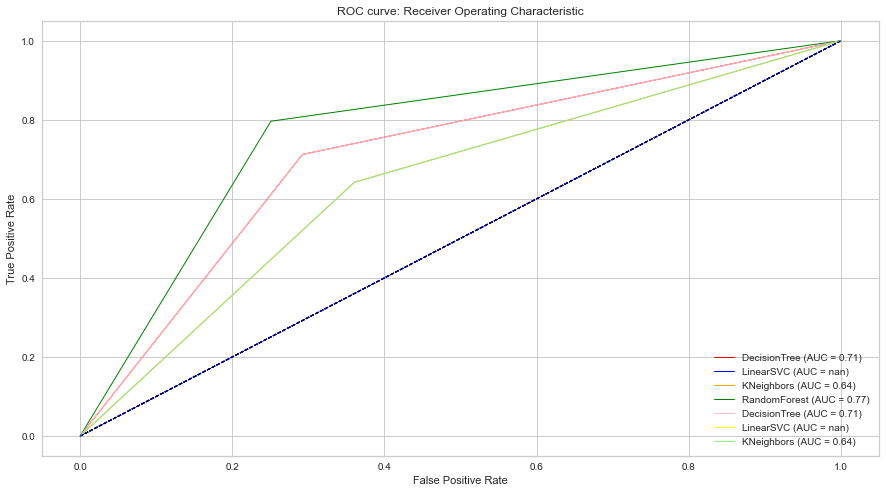

In [45]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")